Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9845 entries, 0 to 9844
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  9845 non-null   object
 1   label     9845 non-null   object
dtypes: object(2)
memory usage: 154.0+ KB
None

All Data:
                                                      filename   label
                                              a.0JWo-James.jpg       a
                                      a.0xvU-Lutian Grace .jpg       a
                                              a.11PX-James.jpg       a
                                              a.1CQN-James.jpg       a
                                      a.1Jjh-Lutian Grace .jpg       a
                                              a.2aoN-James.jpg       a
                                      a.2cqF-Luntian Grace.jpg       a
                                              a.30tp-James.jpg       a
                            

C:\Users\Sam\AppData\Local\Temp\ipykernel_22504\456863599.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=double_letter_counts, y='label', x='count', palette='viridis')


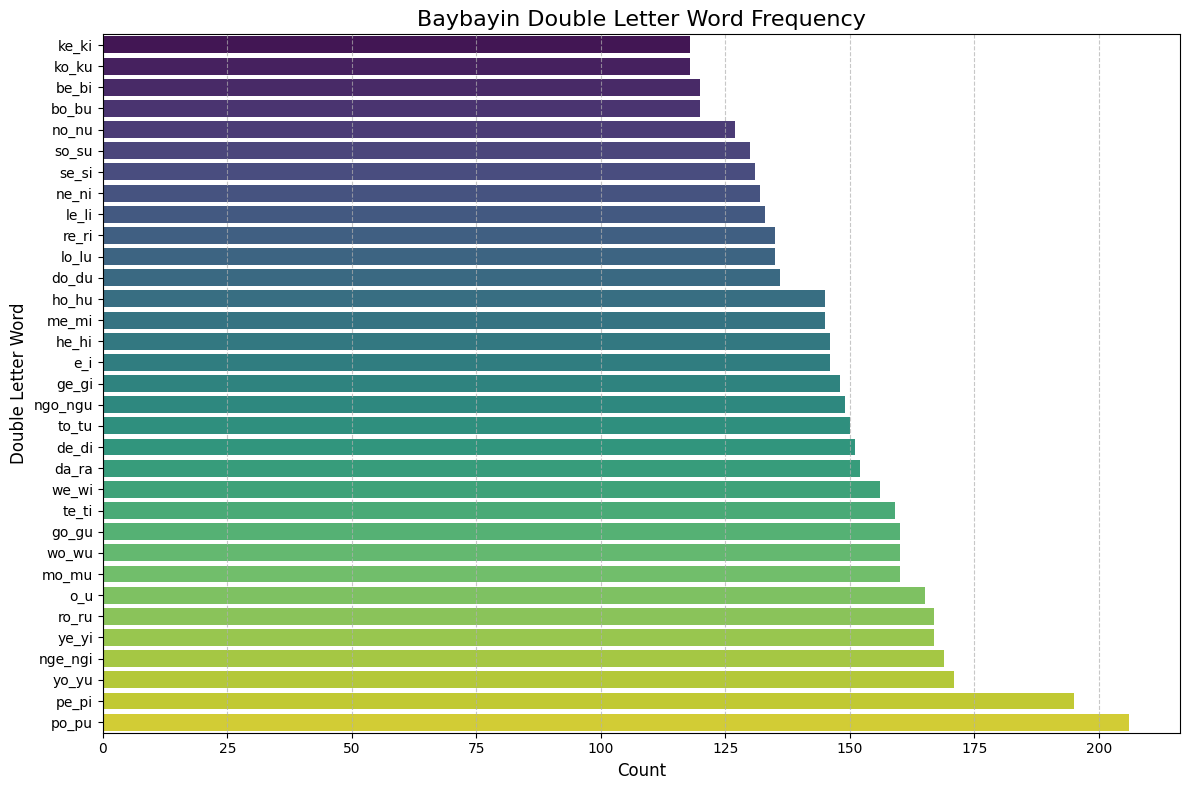

C:\Users\Sam\AppData\Local\Temp\ipykernel_22504\456863599.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=single_letter_counts, y='label', x='count', palette='viridis')


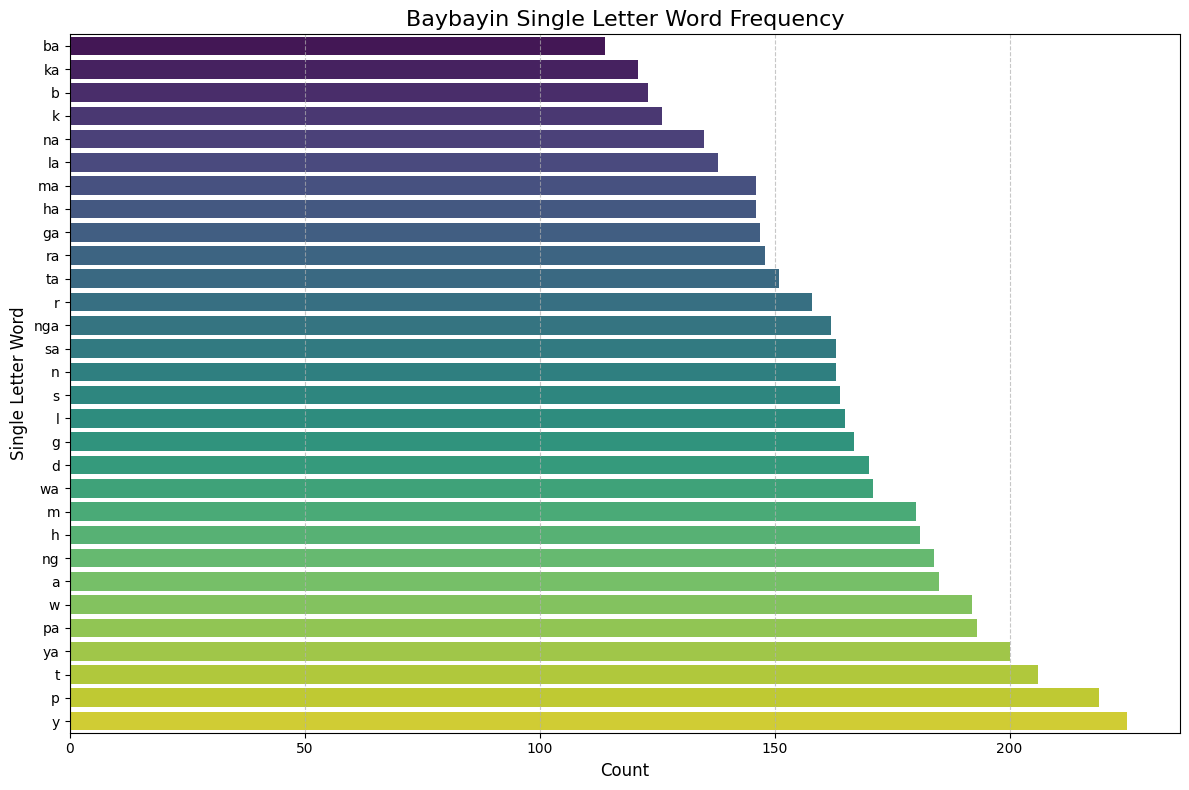

C:\Users\Sam\AppData\Local\Temp\ipykernel_22504\456863599.py:152: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=char_df, x='character', y='count', palette='crest')


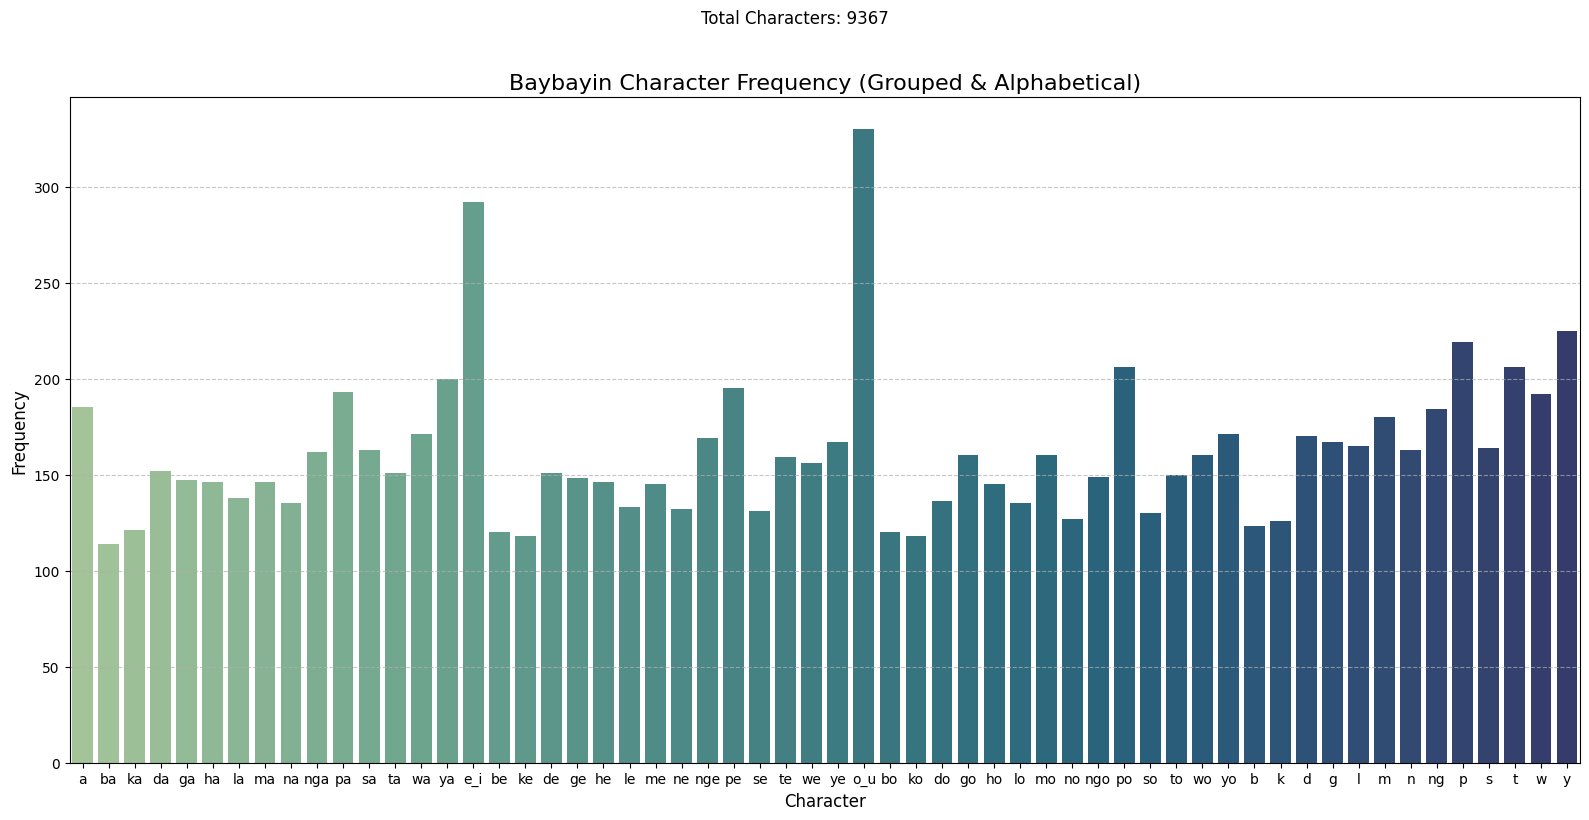

No image dimensions found in the CSV. Skipping the correlation heatmap.

✅ Kudlit Summary (Strict Filter Applied):
                               Type  Count
0            Top Kudlit (Valid e/i)   1780
1         Bottom Kudlit (Valid o/u)   1758
2           Cross Kudlit (b–y only)    698
3  Vowel Characters (Single-letter)    185
4          No Kudlit (a, ba, ka...)   2170


C:\Users\Sam\AppData\Local\Temp\ipykernel_22504\456863599.py:253: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=kudlit_summary_filtered, x="Count", y="Type", palette="rocket")


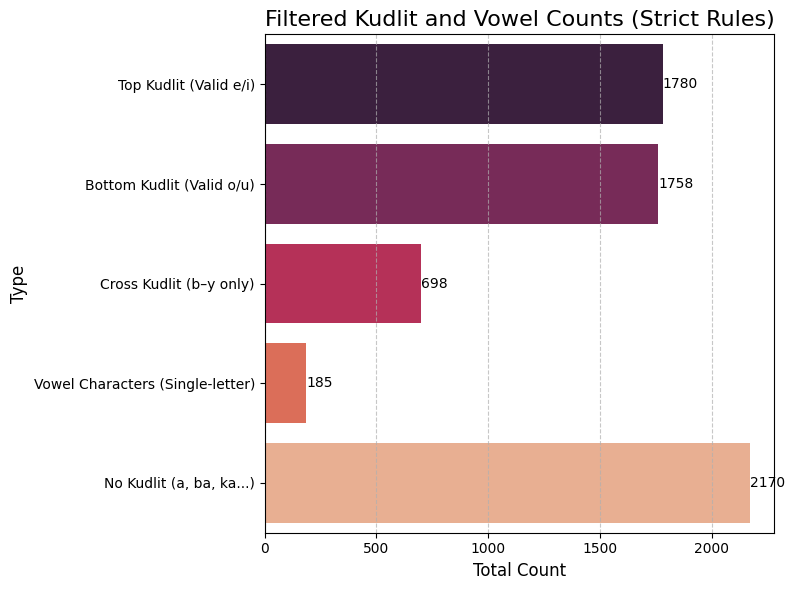

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import cv2
import numpy as np


# Load CSV File with Labels

csv_file = "pics_labels.csv"
df = pd.read_csv(csv_file)

if 'filename' not in df.columns or 'label' not in df.columns:
    print("CSV file must contain 'filename' and 'label' columns.")
    exit()

print("Dataset Summary:")
print(df.info())
print("\nAll Data:")
print(df.to_string(index=False))


# Kudlit Detection Section

def detect_kudlits(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return {"top_kudlit": 0, "bottom_kudlit": 0, "cross_under": 0}

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    height = img.shape[0]
    top_kudlit = 0
    bottom_kudlit = 0
    cross_under = 0

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h

        if area < 150:
            center_y = y + h // 2
            if center_y < height * 0.3:
                top_kudlit += 1
            elif center_y > height * 0.7:
                bottom_kudlit += 1
                aspect_ratio = w / float(h)
                if 0.8 < aspect_ratio < 1.2:
                    cross_under += 1

    return {
        "top_kudlit": top_kudlit,
        "bottom_kudlit": bottom_kudlit,
        "cross_under": cross_under
    }

# Process all images
image_folder = "Dataset"
kudlit_data = []

for _, row in df.iterrows():
    image_path = os.path.join(image_folder, row['filename'])
    kudlit_info = detect_kudlits(image_path)
    kudlit_data.append(kudlit_info)

# Merge kudlit info
df = pd.concat([df, pd.DataFrame(kudlit_data)], axis=1)

print("\nData with kudlit detection:")
print(df.to_string(index=False))


# 2. Separate Word Frequency Distribution (Horizontal Bar Plot for Single and Double Letters)

# Split the words into double-lettered (with '_') and single-lettered words
double_letters = df['label'].str.contains('_')
single_letters = ~double_letters

# Separate the data
double_letter_counts = df[double_letters]['label'].value_counts().reset_index()
single_letter_counts = df[single_letters]['label'].value_counts().reset_index()

# Rename columns for clarity
double_letter_counts.columns = ['label', 'count']
single_letter_counts.columns = ['label', 'count']

# Sort both datasets by count for better visualization
double_letter_counts = double_letter_counts.sort_values(by='count', ascending=True)
single_letter_counts = single_letter_counts.sort_values(by='count', ascending=True)


# 2.1. Plot for Double Letter Words

plt.figure(figsize=(12, 8))
sns.barplot(data=double_letter_counts, y='label', x='count', palette='viridis')

plt.title("Baybayin Double Letter Word Frequency", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Double Letter Word", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2.2. Plot for Single Letter Words

plt.figure(figsize=(12, 8))
sns.barplot(data=single_letter_counts, y='label', x='count', palette='viridis')

plt.title("Baybayin Single Letter Word Frequency", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Single Letter Word", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# 3. Baybayin Character Frequency (Grouped and Alphabetical)

# Define character mapping based on the chart
baybayin_letters = [
    'a', 'ba', 'ka', 'da', 'ga', 'ha', 'la', 'ma', 'na', 'nga', 'pa', 'sa', 'ta', 'wa', 'ya',
    'e_i', 'be', 'ke', 'de', 'ge', 'he', 'le', 'me', 'ne', 'nge', 'pe', 'se', 'te', 'we', 'ye',
    'o_u', 'bo', 'ko', 'do', 'go', 'ho', 'lo', 'mo', 'no', 'ngo', 'po', 'so', 'to', 'wo', 'yo',
    'b', 'k', 'd', 'g', 'l', 'm', 'n', 'ng', 'p', 's', 't', 'w', 'y'
]

# Flatten and normalize
labels = df['label'].str.replace('-', '').str.split('_').explode().dropna()
def normalize_baybayin_char(char):
    if char in ['e', 'i']:
        return 'e_i'
    elif char in ['o', 'u']:
        return 'o_u'
    return char

normalized = labels.apply(normalize_baybayin_char)
char_counts = normalized.value_counts().to_dict()
char_counts_complete = {char: char_counts.get(char, 0) for char in baybayin_letters}
char_df = pd.DataFrame(list(char_counts_complete.items()), columns=['character', 'count'])

plt.figure(figsize=(16, 8))
sns.barplot(data=char_df, x='character', y='count', palette='crest')

plt.title("Baybayin Character Frequency (Grouped & Alphabetical)", fontsize=16)
plt.xlabel("Character", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle(f"Total Characters: {char_df['count'].sum()}", fontsize=12, y=1.02)

plt.tight_layout()
plt.show()

# 4. Correlation Heatmap (if image size is available)

if 'image_width' in df.columns and 'image_height' in df.columns:
    corr_matrix = df[['image_width', 'image_height']].corr()
    plt.figure(figsize=(6, 4))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()
else:
    print("No image dimensions found in the CSV. Skipping the correlation heatmap.")

# 5. Kudlit Type Summary (Strict Baybayin Rules Applied)

# Valid sets
top_vowel_suffixes = ['e', 'i']
bottom_vowel_suffixes = ['o', 'u']
cross_consonants = ['b', 'k', 'd', 'g', 'l', 'm', 'n', 'ng', 's', 't', 'w', 'y']
no_kudlit_valid = ['a', 'ba', 'ka', 'da', 'ga', 'ha', 'la', 'ma', 'na', 'nga', 'pa', 'sa', 'ta', 'wa', 'ya']

# Totals
valid_top_kudlit = 0
valid_bottom_kudlit = 0
valid_cross_kudlit = 0
vowel_single_letter_total = 0
no_kudlit_total = 0

for _, row in df.iterrows():
    label = row['label'].replace('-', '')
    parts = label.split('_')

    # Check for valid top kudlit (e/i only)
    for part in parts:
        if any(part.endswith(v) for v in top_vowel_suffixes):
            if row['top_kudlit'] > 0:
                valid_top_kudlit += 1
                break

    # Check for valid bottom kudlit (o/u only)
    for part in parts:
        if any(part.endswith(v) for v in bottom_vowel_suffixes):
            if row['bottom_kudlit'] > 0:
                valid_bottom_kudlit += 1
                break

    # Check for valid cross under consonants
    for part in parts:
        if part in cross_consonants and row['cross_under'] > 0:
            valid_cross_kudlit += 1
            break

    # Count single-letter vowel characters
    if len(parts) == 1 and parts[0] in ['a', 'e', 'i', 'o', 'u']:
        vowel_single_letter_total += 1

    # Check for no kudlit (valid base characters only)
    if row['top_kudlit'] == 0 and row['bottom_kudlit'] == 0 and row['cross_under'] == 0:
        if all(part in no_kudlit_valid for part in parts):
            no_kudlit_total += 1

# Create summary table
kudlit_summary_filtered = pd.DataFrame({
    "Type": [
        "Top Kudlit (Valid e/i)",
        "Bottom Kudlit (Valid o/u)",
        "Cross Kudlit (b–y only)",
        "Vowel Characters (Single-letter)",
        "No Kudlit (a, ba, ka...)"
    ],
    "Count": [
        valid_top_kudlit,
        valid_bottom_kudlit,
        valid_cross_kudlit,
        vowel_single_letter_total,
        no_kudlit_total
    ]
})

print("\n✅ Kudlit Summary (Strict Filter Applied):")
print(kudlit_summary_filtered)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=kudlit_summary_filtered, x="Count", y="Type", palette="rocket")

for i, row in kudlit_summary_filtered.iterrows():
    plt.text(row['Count'] + 0.5, i, str(row['Count']), va='center', fontsize=10)

plt.title("Filtered Kudlit and Vowel Counts (Strict Rules)", fontsize=16)
plt.xlabel("Total Count", fontsize=12)
plt.ylabel("Type", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



